![NVIDIA Logo](images/nvidia.png)

# Evaluate P-tuning

In this notebook we evaluate the performance of the 3 p-tuned GPT models on the PubMedQA question answering task.

---

## Learning Objectives

By the time you complete this notebook you will be able to:
- Evaluate p-tuning performance for all 3 models across our entire test data.

---

## Imports

In [1]:
import json

from tqdm.notebook import tqdm

from llm_utils.nemo_service_models import NemoServiceBaseModel
from llm_utils.models import PtuneableModels
from llm_utils.helpers import plot_experiment_results, accuracy_score
from llm_utils.pubmedqa import generate_prompt_and_answer, strip_response

---

## List Models

In this notebook we import models that support p-tuning. Of note is that the GPT43B model is a slightly different variant than the GPT43B model we have been using (`gpt-43b-001`) and that LLaMA-2-70B (not the chat variant) is also available for p-tuning, although we are not using it to the end in this workshop.

In [2]:
PtuneableModels.list_models()

gpt8b: gpt-8b-000
gpt20b: gpt20b
gpt43b: gpt-43b-002
llama70b: llama-2-70b-hf


---

## Load Test Data

We begin by loading our `prompts_and_answers` test data created in a previous notebook from file.

In [3]:
prompts_and_answers = json.load(open('data/pubmedqa_panda_test.json','r'))

---

## One Model, Many Customizations

One of the big plusses of p-tuning is that the customization lives in the small prompt encoder network we trained during p-tuning. This means that we can simply swap the prompt encoder in and out when we want to use the customization vs. when we do not.

Additionally, if we have multiple p-tuning customizations that were performed on the same model, we can use a single instance of the LLM and simply use a variety of p-tuned prompt encoders to enable several kinds of customized behavior without the need to host multiple instances of the LLM.

In the case of NeMo Service, the service is taking care of these steps on our behalf, which is lovely. If you're performing PEFT customizations with other hosted services you may find the same.

If you are working with your own local models outside the context of a hosted service, say with [NeMo Framework](https://docs.nvidia.com/nemo-framework/user-guide/latest/playbooks/llama2peft.html), [huggingface/peft](https://huggingface.co/blog/peft), or your own PyTorch setup, you would need to manage this yourself.

---

## Using a Customization With NeMo Service

To use a p-tuned model with the NeMo Service we simply need to obtain the `customization_id` obtained after performing the customization. Once we have it, we can include it in calls to the base model that was p-tuned. NeMo Service takes care of managing the LLMs and customization on our behalf.

Typically you would either use `conn.list_customizations` or the web GUI to ascertain your p-tuned models' `customization_id`s, but here we will provide them for you.

---

## Instantiate P-tuned Models

Again we will instantiate instances of 3 NeMo GPT models, but this time passing the appropriate `customization_id` to each. With NeMo Service this is all we have to do to use a model customization.

In [4]:
llms = {}

In [5]:
llms['gpt43b'] = NemoServiceBaseModel(model=PtuneableModels.gpt43b.value, customization_id='47fadeed-746b-4971-8d48-1cd0980d5ddc')
llms['gpt20b'] = NemoServiceBaseModel(model=PtuneableModels.gpt20b.value, customization_id='a2b8960b-a31b-4fe5-9bdf-32f95e751c47')
llms['gpt8b'] = NemoServiceBaseModel(model=PtuneableModels.gpt8b.value, customization_id='1780214f-8582-4e1c-89cd-7488f089e167')

---

## Try Zero-shot Prompts With P-tuned Model

We will now try out each of our customized models on a few samples of the PubMedQA test data, just as we did in the zero and few-shot notebooks earlier.

### GPT43B

In [6]:
for prompt, answer in tqdm(prompts_and_answers[:3]):
    response = llms['gpt43b'].generate(prompt, tokens_to_generate=1).strip()
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

  0%|          | 0/3 [00:00<?, ?it/s]

Response from model: no
Actual answer: no
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True



### GPT-20B

Now let's check the 20B.

In [7]:
for prompt, answer in prompts_and_answers[::45]:
    response = llms['gpt20b'].generate(prompt, tokens_to_generate=1).strip()
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

Response from model: 
Actual answer: no
Response from model correct: False

Response from model: 
Actual answer: no
Response from model correct: False

Response from model: 
Actual answer: yes
Response from model correct: False

Response from model: 
Actual answer: no
Response from model correct: False



Strangely it looks like we are getting empty responses. Let's increase the number of tokens generated to investigate.

In [8]:
for prompt, answer in prompts_and_answers[::45]:
    response = llms['gpt20b'].generate(prompt, tokens_to_generate=2).strip()
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

Response from model: no
Actual answer: no
Response from model correct: True

Response from model: yes
Actual answer: no
Response from model correct: False

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: no
Actual answer: no
Response from model correct: True



For reasons we don't yet understand, it looks like generating 2 tokens results in a sensible output.

### GPT-8B

Now let's check the 8B.

In [9]:
for prompt, answer in prompts_and_answers[::45]:
    response = llms['gpt8b'].generate(prompt, tokens_to_generate=1).strip()
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

Response from model: No
Actual answer: no
Response from model correct: False

Response from model: No
Actual answer: no
Response from model correct: False

Response from model: |
Actual answer: yes
Response from model correct: False

Response from model: No
Actual answer: no
Response from model correct: False



At least in our sample, it hasn't gotten any answers correct, but at least for the most part its responses are looking far better than before p-tuning.

---

## Zero-shot Prompting With P-tuned Model on Full Dataset

Now will run evaluate each of the three customized models on the full test data set.

Due to our observations about GPT20B needing 2 tokens to generate a correct response, we'll take care to handle that here.

In [10]:
for name, llm in tqdm(llms.items()):
    underline = "-"*len(name)
    print(f'{name.upper()}\n{underline}\n')

    # Handle 20B needing 2 tokens
    tokens_to_generate = 2 if name == 'gpt20b' else 1
    # 43B p-tuning model is different than previous 43B.
    # Here we give it a model_description to match previous
    # experiments just for better plotting.
    model_description = 'gpt-43b-001' if name == 'gpt43b' else ''
    
    llm.evaluate(prompts_and_answers[:10],
                get_clean_prediction=strip_response,
                write_results_to_csv=True,
                experiment_name='P-tuned',
                csv_file_name='./experiment_results/pubmed_experiment_results.csv',
                model_description=model_description,
                tokens_to_generate=tokens_to_generate)
    print()

  0%|          | 0/3 [00:00<?, ?it/s]

GPT43B
------



  0%|          | 0/10 [00:00<?, ?it/s]

8/10 correct
Accuracy: 0.80

GPT20B
------



  0%|          | 0/10 [00:00<?, ?it/s]

6/10 correct
Accuracy: 0.60

GPT8B
-----



  0%|          | 0/10 [00:00<?, ?it/s]

1/10 correct
Accuracy: 0.10



In [11]:
for llm in llms.values():
    print(llm.experiment_results)

{'P-tuned': {'gpt-43b-001': '0.80'}}
{'P-tuned': {'gpt20b': '0.60'}}
{'P-tuned': {'gpt-8b-000': '0.10'}}


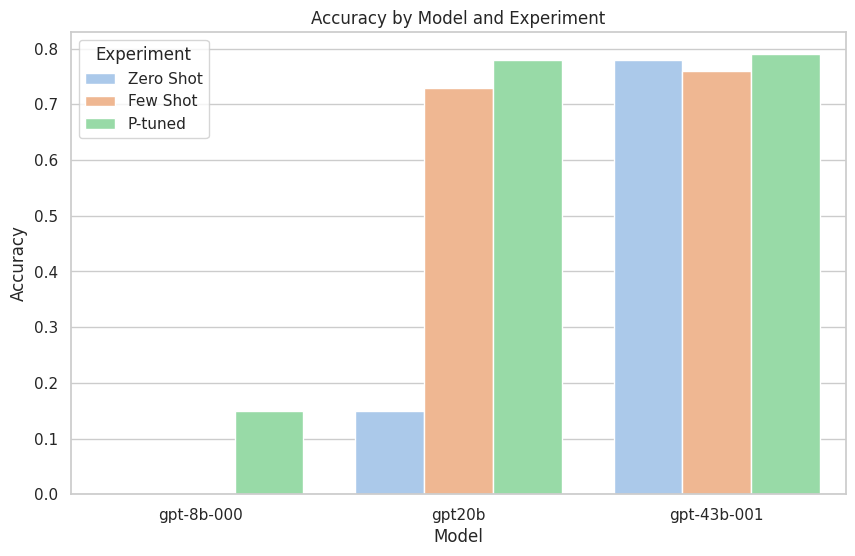

In [12]:
# plot_experiment_results('./experiment_results/pubmed_experiment_results.csv')
plot_experiment_results('./experiment_results/solutions/ptune_pubmed_experiment_results.csv')

### Analysis

For all 3 models, p-tuning over 3 epochs on 700 samples gave us better performance than prompt engineering alone.

For 43B the performance was only slightly improved over one-shot learning. In this experiement 43B had the least to gain from p-tuning.

20B performed marginally better than with 3-shot learning, but drastically better than with zero-shot learning. If you recall just how long our 3-shot prompts were, the excellent news here for 20B is that we can improve performance while simultaneously and drastically reducing the number of tokens we need to send to the model. Not only can this result in better performance, but if we happen to be in a scenario where there is a cost to number of tokens sent, then over time we could really save a lot.

8B is still doing quite poorly (poor little guy 👼) but we should be pleased that for the first time it's not batting 0. Perhaps with additional training time, or data more specifically crafted for this model we could do even better. Additionally, given our observations above, a little additional post-processing, specifically using `.lower()` on our responses, would likely give us a drastic increase in accuracty. We will return to 8B's performance on PubMedQA when after we turn our attention to LoRA.